
[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Dataset shape: (5000, 13)
        age    income  loan_amount  payment_history  credit_utilization  \
0 -2.448885 -4.241233     4.040121        -0.252805           -0.523299   
1 -1.077684 -1.253356     4.499715        -3.867030           -0.023494   
2  0.629683 -1.075405     2.047056        -3.046619           -0.544627   
3 -2.661743 -6.759411     4.659904        -3.077125            0.336875   
4 -1.956613  0.463015     2.471526         0.043815            0.236156   

   num_credit_lines  debt_to_income  employment_years   savings  \
0         -2.441781       -3.450963         -2.542701  1.281397   
1         -2.916986        1.796906         -0.464893 -0.067128   
2         -2.833527        0.730576         -2.476280  0.200603   
3         -0.563940       -1.991883          1.045626  0.423103   
4          1.046261        1.282497         -0.888652 -0.659016   

   late_payments  existing_debt  open_credit_accounts  target  
0      -0.458710       1.678187             -0.501279   

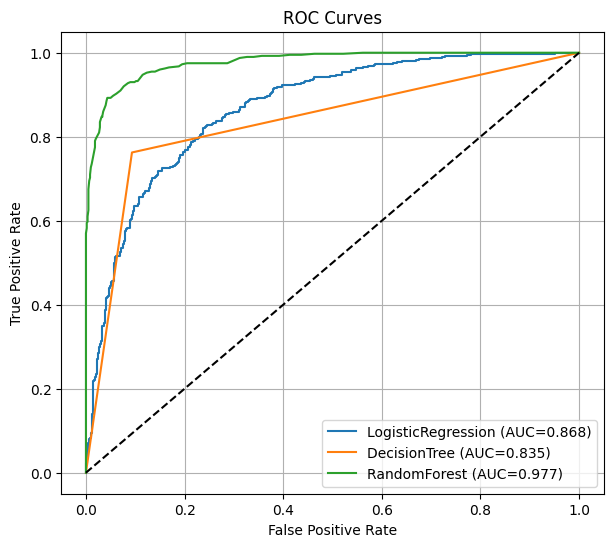

Saved scaler and RandomForest model to current directory.


In [3]:
# Task 1: Credit Scoring Model
# Run this whole cell in a Jupyter notebook.

# Install required packages (run once)
!pip install -q scikit-learn pandas matplotlib

import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import joblib

# 1) Create a synthetic credit dataset (replace with real dataset later)
X, y = make_classification(n_samples=5000, n_features=12, n_informative=6, n_redundant=2,
                           n_clusters_per_class=2, weights=[0.6, 0.4], flip_y=0.01, random_state=42)

feature_names = [
    'age', 'income', 'loan_amount', 'payment_history', 'credit_utilization',
    'num_credit_lines', 'debt_to_income', 'employment_years', 'savings',
    'late_payments', 'existing_debt', 'open_credit_accounts'
]
# If feature_names count mismatch, truncate/extend
if len(feature_names) < X.shape[1]:
    feature_names = feature_names + [f'feat_{i}' for i in range(len(feature_names), X.shape[1])]
elif len(feature_names) > X.shape[1]:
    feature_names = feature_names[:X.shape[1]]

df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

# Quick look
print("Dataset shape:", df.shape)
print(df.head())

# 2) Train-test split
X = df.drop(columns='target').values
y = df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 3) Scale features
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

# 4) Train models
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}

trained = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_s, y_train)
    trained[name] = model

# 5) Evaluate
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    if y_proba is not None:
        roc = roc_auc_score(y_test, y_proba)
        print(f"{name} ROC-AUC: {roc:.4f}")
    else:
        print(f"{name} has no predict_proba; skipping ROC-AUC.")

for name, model in trained.items():
    evaluate_model(name, model, X_test_s, y_test)

# 6) Plot ROC for models that have predict_proba
plt.figure(figsize=(7,6))
for name, model in trained.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_s)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid(True)
plt.show()

# 7) Save one model and scaler
joblib.dump(scaler, "credit_scaler.joblib")
joblib.dump(trained['RandomForest'], "credit_random_forest.joblib")
print("Saved scaler and RandomForest model to current directory.")
